# Observing runs Directory setup & Access

In [1]:
paper_name = "new_mnist"

In [2]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
from sklearn.metrics import roc_auc_score, accuracy_score, log_loss, precision_score, recall_score, f1_score

import matplotlib.pyplot as plt

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os, sys
import errno

# make a directory if it does not exist
def make_dir_if_not_exist(used_path):
    if not os.path.isdir(used_path):
        try:
            os.mkdir(used_path)
        except OSError as exc:
            if exc.errno != errno.EEXIST:
                raise exc
            else:
                raise ValueError(f'{used_path} directoy cannot be created because its parent directory does not exist.')

In [5]:
# make directories if they do not exist
for paper_name_here in ["new_mnist","test13","gpSVHN"]:
  make_dir_if_not_exist("/content/drive/MyDrive/data_papers/")
  make_dir_if_not_exist(f"/content/drive/MyDrive/data_papers/{paper_name_here}")
  make_dir_if_not_exist(f"/content/drive/MyDrive/data_papers/{paper_name_here}/model_features/")
  make_dir_if_not_exist(f"/content/drive/MyDrive/data_papers/{paper_name_here}/concatenated_model_features/")
  make_dir_if_not_exist(f"/content/drive/MyDrive/data_papers/{paper_name_here}/model_checkpoints/")
  make_dir_if_not_exist(f"/content/drive/MyDrive/data_papers/{paper_name_here}/model_history/")
  make_dir_if_not_exist(f"/content/drive/MyDrive/data_papers/{paper_name_here}/model_finals/")
  make_dir_if_not_exist(f"/content/drive/MyDrive/data_papers/{paper_name_here}/gp_collab/")
  make_dir_if_not_exist(f"/content/drive/MyDrive/data_papers/{paper_name_here}/model_predictions/")
  make_dir_if_not_exist(f"/content/drive/MyDrive/data_papers/{paper_name_here}/model_ccs/")
  make_dir_if_not_exist(f"/content/drive/MyDrive/data_papers/{paper_name_here}/summary_results/")
  make_dir_if_not_exist(f"/content/drive/MyDrive/data_papers/{paper_name_here}/summary_results/temp/")


In [6]:
%pip install ipython-autotime

In [7]:
%load_ext autotime

time: 96.7 µs (started: 2022-04-04 12:36:34 +00:00)


In [8]:
import tensorflow as tf
AUTOTUNE = tf.data.AUTOTUNE


time: 2.51 s (started: 2022-04-04 12:36:34 +00:00)


In [9]:
# Set up the imports
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras import regularizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Concatenate, Add, Activation
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import pandas as pd
import numpy as np

import site
import os
import tensorflow as tf
import pandas as pd
import h5py as h5
import matplotlib.pyplot as plt
import errno
import numpy as np
import itertools
import multiprocessing
import json
import datetime
import random
from collections import defaultdict
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import  Dense, Flatten, Activation, Dropout, Embedding, Conv1D, Conv2D, MaxPooling2D, MaxPooling1D, Concatenate, BatchNormalization, GaussianNoise, AveragePooling2D
from tensorflow.keras.layers import LSTM, TimeDistributed, Permute, Reshape, Lambda, RepeatVector, Input, Multiply, SimpleRNN, GRU, LeakyReLU, Add
from tensorflow.keras.regularizers import L2
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras.utils import to_categorical
from tensorflow.summary import create_file_writer

pd.set_option('display.width', 400)
pd.set_option('display.max_columns', 40)


time: 59.3 ms (started: 2022-04-04 12:36:36 +00:00)


In [10]:
import re
import os

def dir_has_file_with_regex(dir_name, regex_string):
  filenames = [ f"{dir_name}/{dir_entry.name}" for dir_entry in os.scandir(dir_name) if os.path.isfile(f"{dir_name}/{dir_entry.name}") ]   
  filenames = [ fn for fn in filenames if re.match(regex_string, fn, re.IGNORECASE) ]
  return filenames


time: 6.36 ms (started: 2022-04-04 12:36:36 +00:00)


In [11]:
import re
import os

def dir_has_dir_with_regex(dir_name, regex_string):
  dirnames = [ f"{dir_name}/{dir_entry.name}" for dir_entry in os.scandir(dir_name) if os.path.isdir(f"{dir_name}/{dir_entry.name}") ]   
  dirnames = [ fn for fn in dirnames if re.match(regex_string, fn, re.IGNORECASE) ]
  return dirnames


time: 5.67 ms (started: 2022-04-04 12:36:36 +00:00)


# data load and data util funcs

In [58]:
# Run this cell to load the dataset 
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

mnist = fetch_openml('mnist_784', cache=False)
X = mnist.data.astype('float32')
y = mnist.target.astype('int64')
X /= 255.0
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

time: 1min 12s (started: 2022-04-04 14:46:54 +00:00)


In [59]:
def plot_example(X, y):
    """Plot the first 5 images and their labels in a row."""
    idx = X.sample(5).index
    for i, (img, y) in enumerate(zip(X.loc[idx].to_numpy().reshape(5, 28, 28), y.loc[idx])):
        plt.subplot(151 + i)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
        plt.title(y)

time: 5.79 ms (started: 2022-04-04 14:48:07 +00:00)


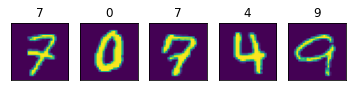

time: 194 ms (started: 2022-04-04 14:48:07 +00:00)


In [60]:
plot_example(X_train, y_train)

In [61]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
# X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
# X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

# Rescale the images from [0,255] to the [0.0,1.0] range.
X_train, X_test = X_train[..., np.newaxis]/255.0, X_test[..., np.newaxis]/255.0
# X_validation = X_validation[..., np.newaxis]/255.0

# print("Number of original training examples:", len(x_train))
# print("Number of original test examples:", len(x_test))

# print( X_train.shape, X_validation.shape, X_test.shape)
print( X_train.shape, X_validation.shape)

(60000, 28, 28, 1) (6300, 784)
time: 470 ms (started: 2022-04-04 14:48:07 +00:00)


In [62]:
# np.unique(y_train.head(100))
paper_name

'new_mnist'

time: 3.9 ms (started: 2022-04-04 14:48:07 +00:00)


In [63]:
train_data = X_train
# validation_data = X_validation
test_data = X_test
train_targets = y_train
# validation_targets = y_validation
test_targets = y_test

time: 2.85 ms (started: 2022-04-04 14:48:07 +00:00)


In [64]:
from pprint import pprint as pp
pp(train_data.shape)
pp(test_data.shape)
# pp(validation_data.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)
time: 4.3 ms (started: 2022-04-04 14:48:07 +00:00)


In [65]:
# extracts the layer from a model using the name
def get_layer_by_name(layers, name, return_first=True):
    matching_named_layers = [l for l in layers if l.name == name]
    if not matching_named_layers:
        return None
    return matching_named_layers[0] if return_first else matching_named_layers


time: 4.26 ms (started: 2022-04-04 14:48:07 +00:00)


In [66]:
# plotting utilities for the history of the fit
def plot_history(history):
    acc_keys = [k for k in history.history.keys() if 'accuracy' in k]
    loss_keys = [k for k in history.history.keys() if not k in acc_keys]
    for k, v in history.history.items():
        if k in acc_keys:
            plt.figure(1)
            plt.plot(v)
        else:
            plt.figure(2)
            plt.plot(v)
    plt.figure(1)
    plt.title('Accuracy vs. epochs')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(acc_keys, loc='lower right')
    plt.figure(2)
    plt.title('Loss vs. epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loss_keys, loc='upper right')
    plt.show()

def plot_history_df(history):
    acc_keys = [k for k in history.columns.values if 'accuracy' in k]
    loss_keys = [k for k in history.columns.values if not k in acc_keys and not k in ['epoch']]
    for k, v in history.items():
        if k in acc_keys:
            plt.figure(1)
            plt.plot(v)
        if k in loss_keys:
            plt.figure(2)
            plt.plot(v)
    plt.figure(1)
    plt.title('Accuracy vs. epochs')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(acc_keys, loc='lower right')
    plt.figure(2)
    plt.title('Loss vs. epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loss_keys, loc='upper right')
    plt.show()   


time: 36.7 ms (started: 2022-04-04 14:48:07 +00:00)


In [67]:
import timeit

time: 1.32 ms (started: 2022-04-04 14:48:07 +00:00)


In [68]:
LEARNING_RATE_EXP_DECAY = 0.6
LEARNING_RATE = 0.01

time: 1.63 ms (started: 2022-04-04 14:48:07 +00:00)


In [69]:
def get_one_hot(targets, nb_classes):
    res = np.eye(nb_classes)[np.array(targets).reshape(-1)]
    return res.reshape(list(targets.shape)+[nb_classes])

time: 3.74 ms (started: 2022-04-04 14:48:07 +00:00)


In [70]:
train_targets_one_hot = get_one_hot(train_targets, len(np.unique(np.array(train_targets))) )
test_targets_one_hot = get_one_hot(test_targets, len(np.unique(np.array(train_targets))) )

time: 11.9 ms (started: 2022-04-04 14:48:07 +00:00)


In [71]:
from pprint import pprint as pp
from operator import mul
from functools import reduce
train_data_flat = tf.reshape(tf.convert_to_tensor(train_data, dtype=tf.float32), 
                              [train_data.shape[0], reduce(mul, train_data.shape[1:-1], 1)])
test_data_flat = tf.reshape(tf.convert_to_tensor(test_data, dtype=tf.float32), 
                              [test_data.shape[0], reduce(mul, test_data.shape[1:-1], 1)])

# train_data.dtype

time: 120 ms (started: 2022-04-04 14:48:07 +00:00)


# Layer Extraction functions

In [72]:
def get_features_for_layer_using_subbatches(features_files, selected_base_patterns, model_dirs, num_of_models):
 
  used_base_patterns = sorted(random.sample(selected_base_patterns, num_of_models))
  used_base_patterns_core = [md.split("features")[0] for md in used_base_patterns]
  feature_files_used = [ff for ff in features_files if any([ss for ss in used_base_patterns if ss in ff]) ]
  
  feature_files_test = [ff for ff in feature_files_used if "Test" in ff]
  feature_files_train = [ff for ff in feature_files_used if "Train" in ff]

  train_batch_files = sorted([ ff for ff in feature_files_train])
  np_x_train_collab_batch = np.array([np.load(ff) for ff in train_batch_files])
  np_x_train_collab_batch = np.concatenate(np_x_train_collab_batch, axis=0)

  test_batch_files = sorted([ ff for ff in feature_files_test])
  np_x_test_collab_batch = np.array([np.load(ff) for ff in test_batch_files])
  np_x_test_collab_batch = np.concatenate(np_x_test_collab_batch, axis=0)

  models_used = [tf.keras.models.load_model(mdir) for mdir in model_dirs if any([ss for ss in used_base_patterns_core if ss in mdir]) ]

  # if np_x_validation_collab is None:
  #   np_x_validation_collab = np_x_validation_collab_batch.copy()
  # else:
  #   np_x_validation_collab = np.concatenate(
  return models_used, np_x_train_collab_batch, np_x_test_collab_batch  

time: 25.5 ms (started: 2022-04-04 14:48:08 +00:00)


In [73]:
def get_individual_features_for_layer_using_subbatches(features_files, 
                                                       selected_base_patterns, 
                                                       model_dirs, 
                                                       num_of_models,
                                                       split_pattern = None):
 
  used_base_patterns = None
  if split_pattern is None:
    used_base_patterns = sorted(random.sample(selected_base_patterns, num_of_models))
  else:
     used_base_patterns = [ sorted(random.sample([bp for bp in selected_base_patterns if string_grab in bp], num_to_grab)) for string_grab,num_to_grab in split_pattern.items()]
     used_base_patterns = [val for sublist in used_base_patterns for val in sublist]   


  used_base_patterns_core = [md.split("features")[0] for md in used_base_patterns]
  feature_files_used = [ff for ff in features_files if any([ss for ss in used_base_patterns if ss in ff]) ]
  
  feature_files_test = [ff for ff in feature_files_used if "Test" in ff]
  feature_files_train = [ff for ff in feature_files_used if "Train" in ff]

  train_batch_files = sorted([ ff for ff in feature_files_train])
  np_x_train_collab_batch = np.array([np.load(ff) for ff in train_batch_files])
  # np_x_train_collab_batch = np.concatenate(np_x_train_collab_batch, axis=0)

  test_batch_files = sorted([ ff for ff in feature_files_test])
  np_x_test_collab_batch = np.array([np.load(ff) for ff in test_batch_files])
  # np_x_test_collab_batch = np.concatenate(np_x_test_collab_batch, axis=0)

  models_used = [tf.keras.models.load_model(mdir) for mdir in model_dirs if any([ss for ss in used_base_patterns_core if ss in mdir]) ]

  # if np_x_validation_collab is None:
  #   np_x_validation_collab = np_x_validation_collab_batch.copy()
  # else:
  #   np_x_validation_collab = np.concatenate(
  return models_used, np_x_train_collab_batch, np_x_test_collab_batch, used_base_patterns_core

time: 35 ms (started: 2022-04-04 14:48:08 +00:00)


In [74]:
def get_likelihood(num_of_functions):
  invlink = gp.likelihoods.RobustMax(num_of_functions)  # Robustmax inverse link function
  likelihood = gp.likelihoods.MultiClass(num_of_functions, invlink=invlink)  # Multiclass likelihood
  return likelihood
  

time: 3.56 ms (started: 2022-04-04 14:48:08 +00:00)


In [75]:
def get_random_inducing_points(nth_inducing_ratio, np_x_train_i, np_y_train_indiv):

  np_x_train_i = np_x_train_indiv[i]
  data_gp = (np_x_train_i, np_y_train_indiv)

  num_of_independent_vars = data_gp[0].shape[1]
  num_of_classes = np.unique(data_gp[1]).size
  num_of_functions = num_of_classes
  
  idxs_of_induced = sorted(random.sample(range(data_gp[0].shape[0]),int(data_gp[0].shape[0]/nth_inducing_ratio)))
  return data_gp[0][idxs_of_induced,:].copy()  # inducing inputs


time: 8.09 ms (started: 2022-04-04 14:48:08 +00:00)


# Identifiers for file groups

In [114]:
acceptable_string_grabs = [ "FULLCONVNNROT20_", "FULLDENSENN_"]
not_check_model_string = ["arallel","Collab_"]

model_dirs = [  f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/{dir_entry.name}" 
                for dir_entry in os.scandir(f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/") 
                if os.path.isdir(dir_entry) and any(xs in dir_entry.name for xs in acceptable_string_grabs) ]
dnn_model_dirs = [ s for s in model_dirs if "DENSENN" in s and all([ (not ncs in s) for ncs in not_check_model_string])] 
cnn_model_dirs = [ s for s in model_dirs if "CONVNN" in s and all([ (not ncs in s) for ncs in not_check_model_string])] 

model_features_files = [  f"/content/drive/MyDrive/data_papers/{paper_name}/model_features/{file_entry.name}" 
                for file_entry in os.scandir(f"/content/drive/MyDrive/data_papers/{paper_name}/model_features/") 
                if os.path.isfile(file_entry) and any(xs in file_entry.name for xs in acceptable_string_grabs) ]

dnn_features_files = [ s for s in model_features_files if "DENSENN" in s and all([ (not ncs in s) for ncs in not_check_model_string])] 
cnn_features_files = [ s for s in model_features_files if "CONVNN" in s and all([ (not ncs in s) for ncs in not_check_model_string])] 

dnn_identifier = acceptable_string_grabs[1]

cnn_identifier = acceptable_string_grabs[0]

def avgfilter_ensemble_predictions(y_pred_ms, xtest):
  y_preds_ens_prb = np.apply_along_axis(np.mean, 0, y_pred_ms)
  y_preds_ens_idx = np.apply_along_axis(np.argmax, 1, y_preds_ens_prb) 
  # y_preds_ens_idx = y_preds_ens_idx + 1
  return y_preds_ens_idx  


time: 54.7 ms (started: 2022-04-04 15:00:31 +00:00)


In [115]:
acceptable_sota_string_grabs = [ "CNNEMASOTA", "CNNSOTA"]
not_check_model_string = ["arallel","Collab_"]

model_dirs = [  f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/{dir_entry.name}" 
                for dir_entry in os.scandir(f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/") 
                if os.path.isdir(dir_entry) and any(xs in dir_entry.name for xs in acceptable_sota_string_grabs) ]

cnnsota_model_dirs = [ s for s in model_dirs if "CNNSOTA" in s and all([ (not ncs in s) for ncs in not_check_model_string])] 
cnnemasota_model_dirs = [ s for s in model_dirs if "CNNEMASOTA" in s and all([ (not ncs in s) for ncs in not_check_model_string])] 

cnnanysota_model_features_files = [  f"/content/drive/MyDrive/data_papers/{paper_name}/model_features/{file_entry.name}" 
                for file_entry in os.scandir(f"/content/drive/MyDrive/data_papers/{paper_name}/model_features/") 
                if os.path.isfile(file_entry) and any(xs in file_entry.name for xs in acceptable_sota_string_grabs) ]

cnnsota_features_files = [ s for s in cnnanysota_model_features_files if "CNNSOTA" in s and all([ (not ncs in s) for ncs in not_check_model_string])] 
cnnemasota_features_files = [ s for s in cnnanysota_model_features_files if "CNNEMASOTA" in s and all([ (not ncs in s) for ncs in not_check_model_string])] 


time: 40.4 ms (started: 2022-04-04 15:00:31 +00:00)


In [116]:
import random
import re

def get_base_patterns_for_string(features_files, search_string = "Validation", layer_name = "SFTMX", model_type = "DNN"):
  base_patterns_for_validations = []
  for ff in [ s for s in features_files if search_string in s]:
    # validation_search = re.search(f'^.*({model_type}.*_ID.*features_{layer_name}_{search_string})[0-9]+.*$', ff, re.IGNORECASE)
    # validation_search = re.search(f'^.*({model_type}.*features_{layer_name}_{search_string}).*$', ff, re.IGNORECASE)
    validation_search = re.search(f'^.*({model_type}.*features_{layer_name}).*$', ff, re.IGNORECASE)
    if validation_search:
        base_patterns_for_validations.append(validation_search.group(1))

  base_patterns_for_validations = sorted(list(set(base_patterns_for_validations)))
  return base_patterns_for_validations


time: 13 ms (started: 2022-04-04 15:00:31 +00:00)


In [117]:
dnn_base_patterns_train = get_base_patterns_for_string(dnn_features_files, "Train", "SFTMX", "DENSENN")
dnn_base_patterns_test = get_base_patterns_for_string(dnn_features_files, "Test", "SFTMX", "DENSENN")
dnn_base_patterns_sftmx = list(set(dnn_base_patterns_train) &  set(dnn_base_patterns_test))

dnn_base_patterns_train = get_base_patterns_for_string(dnn_features_files, "Train", "LD1", "DENSENN")
dnn_base_patterns_test = get_base_patterns_for_string(dnn_features_files, "Test", "LD1", "DENSENN")
dnn_base_patterns_ld = list(set(dnn_base_patterns_train) & set(dnn_base_patterns_test))


time: 3.44 ms (started: 2022-04-04 15:00:31 +00:00)


In [118]:
cnn_base_patterns_train_sftmx = get_base_patterns_for_string(cnn_features_files, "Train", "SFTMX", "CONVNN")
cnn_base_patterns_test_sftmx = get_base_patterns_for_string(cnn_features_files, "Test", "SFTMX", "CONVNN")
cnn_base_patterns_sftmx = list(set(cnn_base_patterns_train_sftmx) & set(cnn_base_patterns_test_sftmx))

cnn_base_patterns_train_ld = get_base_patterns_for_string(cnn_features_files, "Train", "LD1", "CONVNN")
cnn_base_patterns_test_ld = get_base_patterns_for_string(cnn_features_files, "Test", "LD1", "CONVNN")
cnn_base_patterns_ld = list(set(cnn_base_patterns_train_ld) & set(cnn_base_patterns_test_ld))

time: 4.24 ms (started: 2022-04-04 15:00:31 +00:00)


In [119]:
cnnsotam3_base_patterns_train_sftmx = get_base_patterns_for_string(cnnsota_features_files, "Train", "SFTMX", "CNNSOTAM3")
cnnsotam3_base_patterns_test_sftmx = get_base_patterns_for_string(cnnsota_features_files, "Test", "SFTMX", "CNNSOTAM3")
cnnsotam3_base_patterns_sftmx = list(set(cnnsotam3_base_patterns_train_sftmx) & set(cnnsotam3_base_patterns_test_sftmx))

cnnsotam5_base_patterns_train_sftmx = get_base_patterns_for_string(cnnsota_features_files, "Train", "SFTMX", "CNNSOTAM5")
cnnsotam5_base_patterns_test_sftmx = get_base_patterns_for_string(cnnsota_features_files, "Test", "SFTMX", "CNNSOTAM5")
cnnsotam5_base_patterns_sftmx = list(set(cnnsotam5_base_patterns_train_sftmx) & set(cnnsotam5_base_patterns_test_sftmx))

cnnsotam7_base_patterns_train_sftmx = get_base_patterns_for_string(cnnsota_features_files, "Train", "SFTMX", "CNNSOTAM7")
cnnsotam7_base_patterns_test_sftmx = get_base_patterns_for_string(cnnsota_features_files, "Test", "SFTMX", "CNNSOTAM7")
cnnsotam7_base_patterns_sftmx = list(set(cnnsotam7_base_patterns_train_sftmx) & set(cnnsotam7_base_patterns_test_sftmx))


time: 8.73 ms (started: 2022-04-04 15:00:31 +00:00)


In [120]:
cnnemasotam3_base_patterns_train_sftmx = get_base_patterns_for_string(cnnemasota_features_files, "Train", "SFTMX", "CNNEMASOTAM3")
cnnemasotam3_base_patterns_test_sftmx = get_base_patterns_for_string(cnnemasota_features_files, "Test", "SFTMX", "CNNEMASOTAM3")
cnnemasotam3_base_patterns_sftmx = list(set(cnnemasotam3_base_patterns_train_sftmx) & set(cnnemasotam3_base_patterns_test_sftmx))

cnnemasotam5_base_patterns_train_sftmx = get_base_patterns_for_string(cnnemasota_features_files, "Train", "SFTMX", "CNNEMASOTAM5")
cnnemasotam5_base_patterns_test_sftmx = get_base_patterns_for_string(cnnemasota_features_files, "Test", "SFTMX", "CNNEMASOTAM5")
cnnemasotam5_base_patterns_sftmx = list(set(cnnemasotam5_base_patterns_train_sftmx) & set(cnnemasotam5_base_patterns_test_sftmx))

cnnemasotam7_base_patterns_train_sftmx = get_base_patterns_for_string(cnnemasota_features_files, "Train", "SFTMX", "CNNEMASOTAM7")
cnnemasotam7_base_patterns_test_sftmx = get_base_patterns_for_string(cnnemasota_features_files, "Test", "SFTMX", "CNNEMASOTAM7")
cnnemasotam7_base_patterns_sftmx = list(set(cnnemasotam7_base_patterns_train_sftmx) & set(cnnemasotam7_base_patterns_test_sftmx))


time: 11 ms (started: 2022-04-04 15:00:31 +00:00)


In [121]:
cnnsota_base_patterns_train_sftmx = get_base_patterns_for_string(cnnsota_features_files, "Train", "SFTMX", "CNNSOTA")
cnnsota_base_patterns_test_sftmx = get_base_patterns_for_string(cnnsota_features_files, "Test", "SFTMX", "CNNSOTA")
cnnsota_base_patterns_sftmx = list(set(cnnsota_base_patterns_train_sftmx) & set(cnnsota_base_patterns_test_sftmx))

cnnemasota_base_patterns_train_sftmx = get_base_patterns_for_string(cnnemasota_features_files, "Train", "SFTMX", "CNNEMASOTA")
cnnemasota_base_patterns_test_sftmx = get_base_patterns_for_string(cnnemasota_features_files, "Test", "SFTMX", "CNNEMASOTA")
cnnemasota_base_patterns_sftmx = list(set(cnnemasota_base_patterns_train_sftmx) & set(cnnemasota_base_patterns_test_sftmx))


time: 6.74 ms (started: 2022-04-04 15:00:31 +00:00)


In [122]:
print( [len(dnn_base_patterns_sftmx), len(dnn_base_patterns_ld), len(cnn_base_patterns_sftmx), len(cnn_base_patterns_ld)] ) 

[5, 5, 5, 5]
time: 1.67 ms (started: 2022-04-04 15:00:31 +00:00)


In [123]:
train_size = train_data_flat.shape[0]
test_size = test_data_flat.shape[0]


time: 1.58 ms (started: 2022-04-04 15:00:31 +00:00)


# load some runs, evaluate and count

In [ ]:
CNN_SOTAM3EMA_STR =  "CNNEMASOTAM3_MNIST"
CNN_SOTAM5EMA_STR =  "CNNEMASOTAM5_MNIST"
CNN_SOTAM7EMA_STR =  "CNNEMASOTAM7_MNIST"

cnn_id = CNN_SOTAM5EMA_STR 

test_accs = []
for model_dir in dir_has_dir_with_regex(f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/", f".*{cnn_id}.*"):
  loaded_model = tf.keras.models.load_model(model_dir)
  test_accs.append(loaded_model.evaluate(test_data, test_targets_one_hot)[1])

In [37]:
np.mean(test_accs)

0.9743500053882599

time: 4.98 ms (started: 2022-04-04 14:10:05 +00:00)


In [ ]:
CNN_SOTAM3_STR =  "CNNSOTAM3_MNIST"
CNN_SOTAM5_STR =  "CNNSOTAM5_MNIST"
CNN_SOTAM7_STR =  "CNNSOTAM7_MNIST"

cnn_id = CNN_SOTAM7_STR 

test_accs = []
for model_dir in dir_has_dir_with_regex(f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/", f".*{cnn_id}.*"):
  loaded_model = tf.keras.models.load_model(model_dir)
  test_accs.append(loaded_model.evaluate(test_data, test_targets_one_hot)[1]) 

313/313 [==============================] - 54s 171ms/step - loss: 0.0727 - categorical_accuracy: 0.9764
time: 5min 53s (started: 2022-04-03 21:45:00 +00:00)


In [ ]:
np.mean(test_accs)

0.9728399991989136

time: 9.84 ms (started: 2022-04-03 21:01:39 +00:00)


In [98]:
import tensorflow.keras.backend as K

CNN_SOTAM3_STR =  "CNNSOTAM3_MNIST"
CNN_SOTAM5_STR =  "CNNSOTAM5_MNIST"
CNN_SOTAM7_STR =  "CNNSOTAM7_MNIST"
CNN_SOTAM3EMA_STR =  "CNNEMASOTAM3_MNIST"
CNN_SOTAM5EMA_STR =  "CNNEMASOTAM5_MNIST"
CNN_SOTAM7EMA_STR =  "CNNSOTAM7EMA_MNIST"  #RENAME!!!

cnn_ids = [CNN_SOTAM3_STR,CNN_SOTAM5_STR,CNN_SOTAM7_STR,CNN_SOTAM3EMA_STR,CNN_SOTAM5EMA_STR,CNN_SOTAM7EMA_STR] 

test_accs = []

trainable_counts = []

for model_id_str in cnn_ids:
  model_dirs = dir_has_dir_with_regex(f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/", f".*{model_id_str}.*")
  print((model_id_str, len(model_dirs)))
  model_dir = model_dirs[0]
  loaded_model = tf.keras.models.load_model(model_dir)
  trainable_counts.append(np.sum([K.count_params(w) for w in loaded_model.trainable_weights]))

trainable_counts


('CNNSOTAM3_MNIST', 5)


('CNNSOTAM5_MNIST', 5)
('CNNSOTAM7_MNIST', 5)


('CNNEMASOTAM3_MNIST', 5)
('CNNEMASOTAM5_MNIST', 5)
('CNNSOTAM7EMA_MNIST', 2)


[1037514, 1148650, 2298106, 1072714, 1148650, 2298106]

time: 18.9 s (started: 2022-04-04 14:49:36 +00:00)


# GPFlow explore

In [ ]:
%pip install gpflow
import gpflow as gp
from gpflow import *

In [35]:
gp.kernels.Linear()

name,class,transform,prior,trainable,shape,dtype,value
Linear.variance,Parameter,Softplus,,True,(),float64,1


time: 64 ms (started: 2022-04-04 13:31:28 +00:00)


In [132]:
import tensorflow_probability as tfp

time: 3.16 ms (started: 2022-04-04 15:14:30 +00:00)


In [144]:
def construct_sum_of_kernels(num_of_independent_vars, base_lengthscales = [1.0]):
  kern_sum = [ gp.kernels.RBF(variance=1.0, lengthscales=base_lengthscales*num_of_independent_vars) + 
    gp.kernels.Matern12(variance=1.0, lengthscales=base_lengthscales*num_of_independent_vars) +
    gp.kernels.Matern32(variance=1.0, lengthscales=base_lengthscales*num_of_independent_vars) + 
    gp.kernels.Matern52(variance=1.0, lengthscales=base_lengthscales*num_of_independent_vars) + 
    gp.kernels.Linear(active_dims=[1]) +
    gp.kernels.Cosine(active_dims=[1]) ]
  
  kern_sum = kern_sum[0]
  kern_sum.kernels[0].variance.prior = tfp.distributions.Gamma(tf.cast(1.0, tf.float64), tf.cast(2.0, tf.float64))
  kern_sum.kernels[1].variance.prior = tfp.distributions.Gamma(tf.cast(1.0, tf.float64), tf.cast(2.0, tf.float64))
  kern_sum.kernels[2].variance.prior = tfp.distributions.Gamma(tf.cast(1.0, tf.float64), tf.cast(2.0, tf.float64))
  kern_sum.kernels[3].variance.prior = tfp.distributions.Gamma(tf.cast(1.0, tf.float64), tf.cast(2.0, tf.float64))
  kern_sum.kernels[4].variance.prior = tfp.distributions.Gamma(tf.cast(1.0, tf.float64), tf.cast(2.0, tf.float64))
  kern_sum.kernels[5].variance.prior = tfp.distributions.Gamma(tf.cast(1.0, tf.float64), tf.cast(2.0, tf.float64))

  return kern_sum


time: 16.8 ms (started: 2022-04-04 15:20:51 +00:00)


In [136]:
num_of_independent_vars = 10
base_lengthscales = [1.0]
kern_sum = [ gp.kernels.RBF(variance=1.0, lengthscales=base_lengthscales*num_of_independent_vars) + 
    gp.kernels.Matern12(variance=1.0, lengthscales=base_lengthscales*num_of_independent_vars) +
    gp.kernels.Matern32(variance=1.0, lengthscales=base_lengthscales*num_of_independent_vars) + 
    gp.kernels.Matern52(variance=1.0, lengthscales=base_lengthscales*num_of_independent_vars) + 
    gp.kernels.Linear(active_dims=[1]) +
    gp.kernels.Cosine(active_dims=[1]) ]
kern_sum = kern_sum[0]

time: 102 ms (started: 2022-04-04 15:19:15 +00:00)


In [143]:
kern_sum.kernels

ListWrapper([<gpflow.kernels.stationaries.SquaredExponential object at 0x7ff22e599ad0>, <gpflow.kernels.stationaries.Matern12 object at 0x7ff28f1cf650>, <gpflow.kernels.stationaries.Matern32 object at 0x7ff227d4a610>, <gpflow.kernels.stationaries.Matern52 object at 0x7ff2988a4510>, <gpflow.kernels.linears.Linear object at 0x7ff28ea5dd50>, <gpflow.kernels.stationaries.Cosine object at 0x7ff29292eb90>])

time: 4.94 ms (started: 2022-04-04 15:20:35 +00:00)


In [ ]:
cnnsota_features_files

In [131]:
cnnsota_num_of_models = 5
cnnsota_model_mix = dict( { "CNNSOTAM3" : 3, "CNNSOTAM5": 2 } )

cnnsota_models_used, cnnsota_np_x_train_indiv, cnnsota_np_x_test_indiv, cnnsota_numb1_core_names = get_individual_features_for_layer_using_subbatches(
                                          cnnsota_features_files, 
                                          cnnsota_base_patterns_sftmx, 
                                          cnnsota_model_dirs, 
                                          cnnsota_num_of_models,
                                          cnnsota_model_mix
                                          )
# merge into one
cnnsota_np_x_train_indiv = np.concatenate(cnnsota_np_x_train_indiv, axis=0)
cnnsota_np_x_test_indiv = np.concatenate(cnnsota_np_x_test_indiv, axis=0)


time: 14.5 s (started: 2022-04-04 15:07:36 +00:00)


In [145]:
from collections import defaultdict

# construct_sum_of_kernels

cnnsota_np_y_train_indiv = train_targets[..., np.newaxis]
cnnsota_np_y_test_indiv = test_targets[..., np.newaxis]

var_list = [1.0]       

number1_cnn_models = defaultdict(lambda: None)

nth_inducing_ratio = 2000

all_name = "_".join(cnnsota_numb1_core_names)

type_name="CNN"
data_gp = (cnnsota_np_x_train_indiv, cnnsota_np_y_train_indiv)
data_gp_test = cnnsota_np_x_test_indiv
data_gp_test_target = cnnsota_np_y_test_indiv
id_str="Test"

num_of_independent_vars = data_gp[0].shape[1]
num_of_classes = np.unique(data_gp[1]).size
num_of_functions = num_of_classes
kernel_to_optimize = construct_sum_of_kernels(num_of_independent_vars, var_list)

# Robustmax Multiclass Likelihood
invlink = gp.likelihoods.RobustMax(num_of_functions)  # Robustmax inverse link function
likelihood = gp.likelihoods.MultiClass(num_of_functions, invlink=invlink)  # Multiclass likelihood
idxs_of_induced = sorted(random.sample(range(data_gp[0].shape[0]),int(data_gp[0].shape[0]/nth_inducing_ratio)))
inducing_inputs = data_gp[0][idxs_of_induced,:].copy()  # inducing inputs
m = gp.models.SVGP(
    kernel=kernel_to_optimize,
    likelihood=likelihood,
    inducing_variable=inducing_inputs,
    num_latent_gps=num_of_functions,
    whiten=True,
    q_diag=True,
)
# do not set_trainable to True on the variance and then set a prior, it won't train it. To train it, just set a prior
# set_trainable(m.kernel.variance, True)
# m.kernel.variance.prior = tfp.distributions.InverseGamma(1.0,1.0)
set_trainable(m.inducing_variable, True)
  


time: 101 ms (started: 2022-04-04 15:20:56 +00:00)
